จงหา Dataset ของหุ้น และใช้ RNN ทำการทำนายราคาหุ้น และ Plot Graph การทำนายออกมาให้เห็น

1) Import Packages

In [ ]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

2) Import Data

In [ ]:
url = '/content/drive/MyDrive/Colab Notebooks/prices-split-adjusted.csv'
df = pd.read_csv(url, index_col=0)

In [ ]:
df.sample(5)

,symbol,open,close,low,high,volume
date,,,,,,
2015-10-02,FE,30.709999,30.950001,30.440001,31.049999,2324300.0
2016-03-08,PEG,44.270000,44.840000,43.970001,44.860001,3632300.0
2011-11-18,NEE,55.529999,55.529999,55.169998,55.810001,1856500.0
2014-05-20,COP,78.500000,78.540001,78.110001,78.680000,4353500.0
2015-09-02,PCLN,1232.439941,1242.869995,1216.050049,1242.920044,413100.0


In [ ]:
symbols = list(set(df.symbol))
print('\nNumber of different stocks: ', len(symbols))
print('Examples:',symbols[:10])


Number of different stocks:  501
Examples: ['PCG', 'ESRX', 'L', 'MO', 'FBHS', 'DLR', 'HOG', 'NFLX', 'BDX', 'CRM']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


In [ ]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


# 3) Extract one stock (choose MSFT)

In [ ]:
df = df[df['symbol']=='MSFT']
df.drop('symbol', axis=1, inplace=True)

In [ ]:
df.head(10)

,open,close,low,high,volume
date,,,,,
2010-01-04,30.620001,30.950001,30.590000,31.100000,38409100.0
2010-01-05,30.850000,30.959999,30.639999,31.100000,49749600.0
2010-01-06,30.879999,30.770000,30.520000,31.080000,58182400.0
2010-01-07,30.629999,30.450001,30.190001,30.700001,50559700.0
2010-01-08,30.280001,30.660000,30.240000,30.879999,51197400.0
2010-01-11,30.709999,30.270000,30.120001,30.760000,68754700.0
2010-01-12,30.150000,30.070000,29.910000,30.400000,65912100.0
2010-01-13,30.260000,30.350000,30.010000,30.520000,51863500.0
2010-01-14,30.309999,30.959999,30.260000,31.100000,63228100.0


# 4) Exploratory Data Analysis

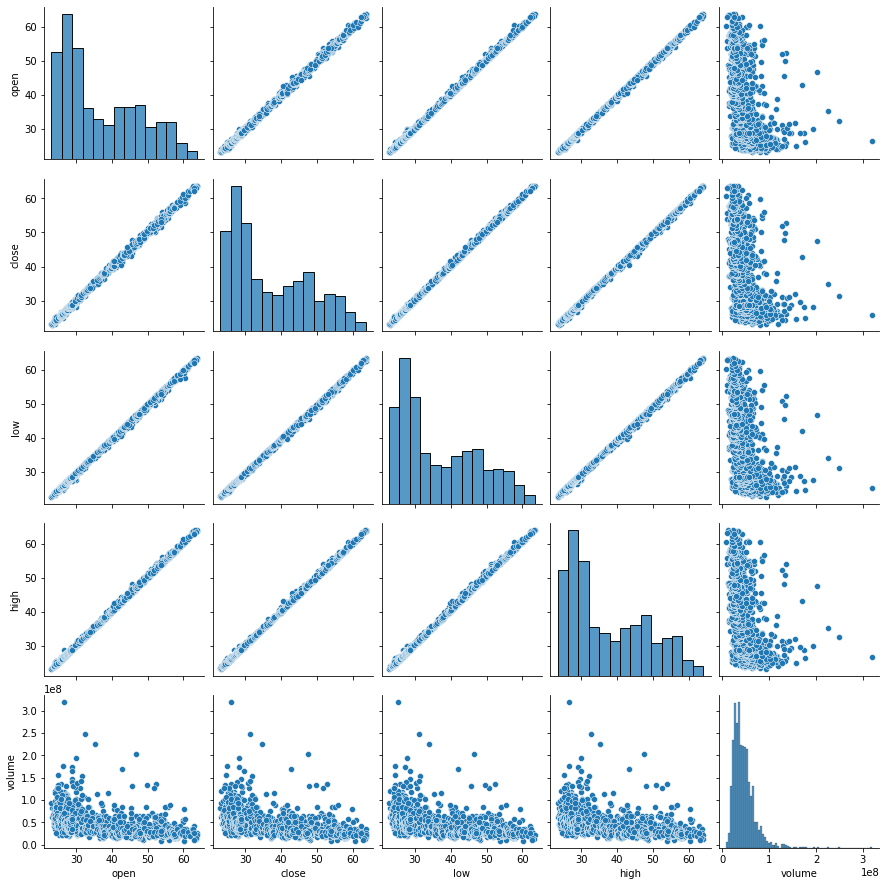

In [ ]:
sns.pairplot(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fece2a54be0>,
      dtype=object)

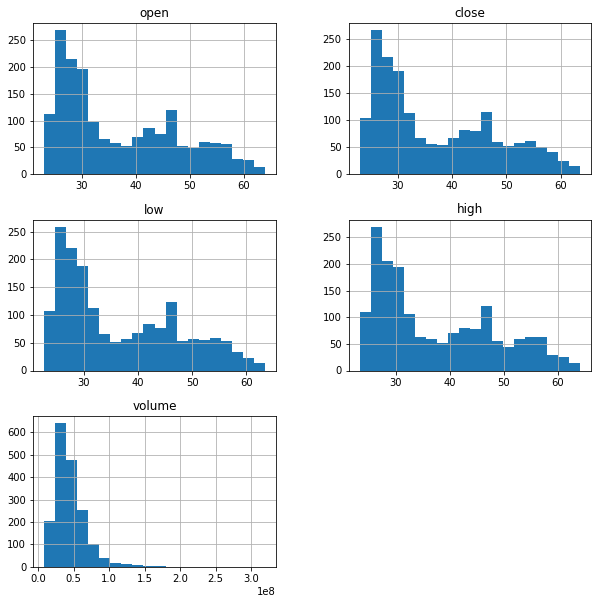

In [ ]:
df.hist(bins=20,figsize=(10,10))

จาก histogram พบว่า การซื้อขายที่เกิดขึ้น มักจะมีราคาต่ำๆเป็นส่วนใหญ่  
สอดคล้องกับ scatter plot ที่เทไปทาง **volume สูงๆ** และ **ราคา (open, close, low, high) ต่ำๆ**

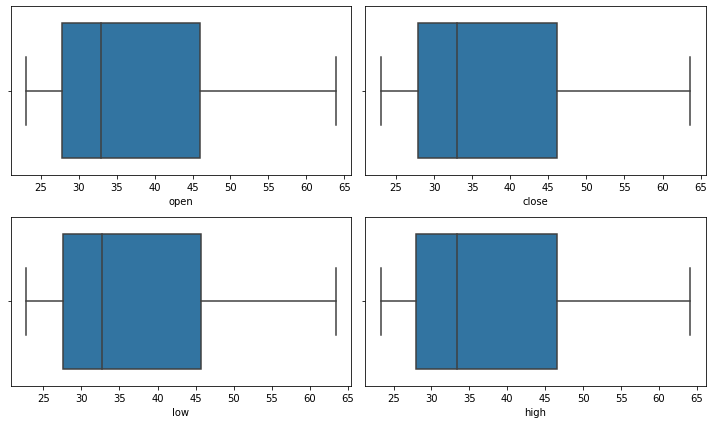

In [ ]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=[10,6])

sns.boxplot(x='open', data=df, ax=ax1)
sns.boxplot(x='close', data=df, ax=ax2)
sns.boxplot(x='low', data=df, ax=ax3)
sns.boxplot(x='high', data=df, ax=ax4)

fig.tight_layout()

ไม่พบ outlier ในฟีเจอร์ open, close, low, high

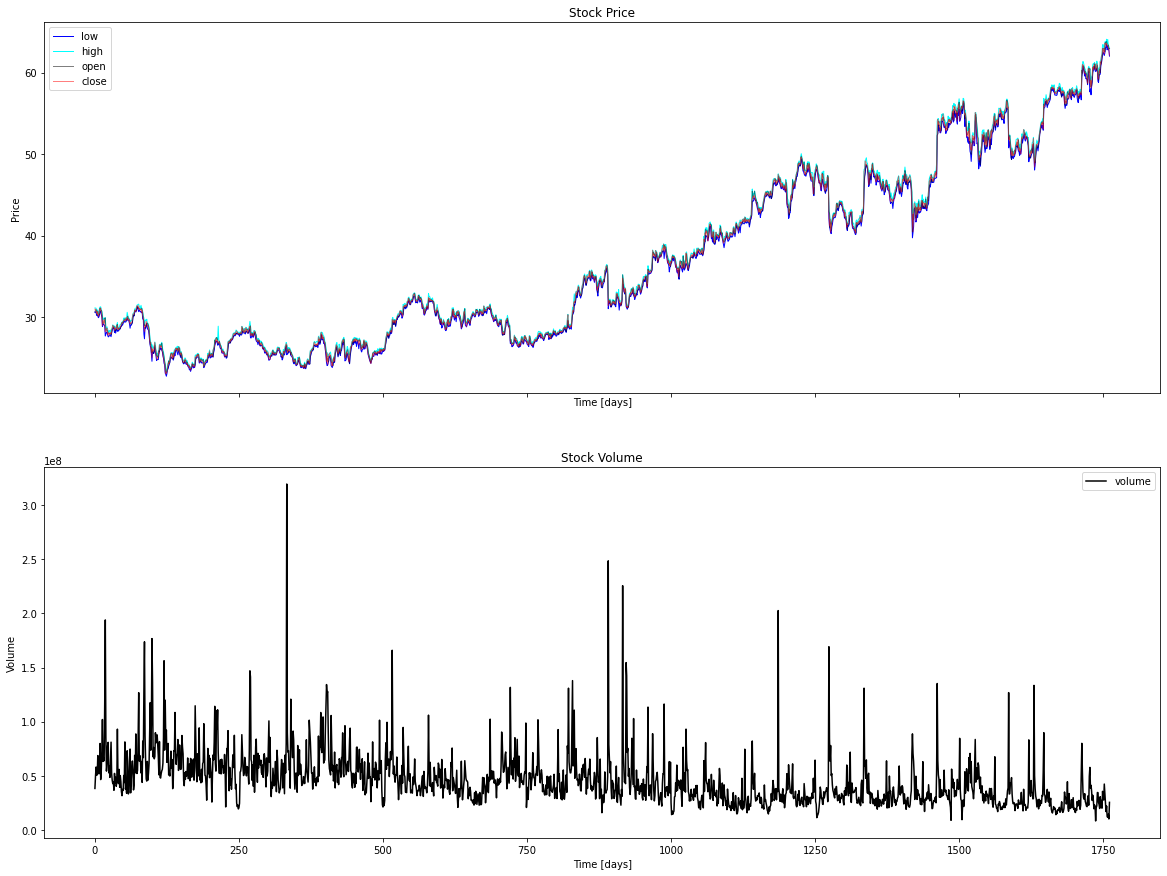

In [ ]:
fig, [ax1,ax2] = plt.subplots(2, 1, sharex=True, figsize=(20,15))

ax1.plot(df['low'].values, color='blue', label='low', lw=1)
ax1.plot(df['high'].values, color='cyan', label='high', lw=1)
ax1.plot(df['open'].values, color='black', label='open', lw=1, alpha=0.5)
ax1.plot(df['close'].values, color='red', label='close', lw=1, alpha=0.5)
ax1.set_title('Stock Price')
ax1.set_xlabel('Time [days]')
ax1.set_ylabel('Price')
ax1.legend(loc='best')

ax2.plot(df['volume'].values, color='black', label='volume')
ax2.set_title('Stock Volume')
ax2.set_xlabel('Time [days]')
ax2.set_ylabel('Volume')
ax2.legend(loc='best')

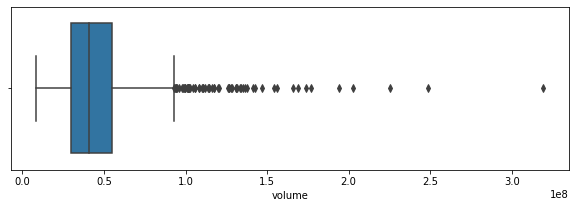

In [ ]:
plt.figure(figsize=(10,3))
sns.boxplot(x='volume', data=df)

พบว่าฟีเจอร์ volume มี outliers เยอะมาก จึงจะ drop ฟีเจอร์นี้

# 5) Manipulate Data

### Drop Feature: Volume

In [ ]:
df.drop('volume', axis=1, inplace=True)

In [ ]:
df['adj close'] = df['close']
df.drop(['close'], 1, inplace=True)

In [ ]:
df.rename(columns={'adj close':'close'}, inplace=True)

In [ ]:
df.head(10)

,open,low,high,close
date,,,,
2010-01-04,30.620001,30.590000,31.100000,30.950001
2010-01-05,30.850000,30.639999,31.100000,30.959999
2010-01-06,30.879999,30.520000,31.080000,30.770000
2010-01-07,30.629999,30.190001,30.700001,30.450001
2010-01-08,30.280001,30.240000,30.879999,30.660000
2010-01-11,30.709999,30.120001,30.760000,30.270000
2010-01-12,30.150000,29.910000,30.400000,30.070000
2010-01-13,30.260000,30.010000,30.520000,30.350000
2010-01-14,30.309999,30.260000,31.100000,30.959999


### Normalise the Data

In [ ]:
dataset = df.values
dataset

array([[30.620001, 30.59    , 31.1     , 30.950001],
       [30.85    , 30.639999, 31.1     , 30.959999],
       [30.879999, 30.52    , 31.08    , 30.77    ],
       ...,
       [63.400002, 62.830002, 63.400002, 62.990002],
       [62.860001, 62.73    , 63.200001, 62.900002],
       [62.959999, 62.029999, 62.990002, 62.139999]])

In [ ]:
min_max_scaler = MinMaxScaler()
scaled = min_max_scaler.fit_transform(df)
scaled

array([[0.1847853 , 0.19321534, 0.1907798 , 0.19551837],
       [0.19042945, 0.19444442, 0.1907798 , 0.19576457],
       [0.19116562, 0.19149459, 0.19028937, 0.19108594],
       ...,
       [0.9892025 , 0.98574243, 0.98283482, 0.98448665],
       [0.97595094, 0.98328417, 0.97793043, 0.98227045],
       [0.97840488, 0.96607667, 0.97278087, 0.96355577]])

In [ ]:
X = scaled[:,:-1]
y = scaled[:,-1]

### Create Train, Validation, Test datasets
Train dataset : 60%  
Validation dataset : 20%  
Test dataset : 20%

In [ ]:
pcnt_train = 0.6
pcnt_val = 0.2

X_train = X[:round(len(X)*pcnt_train),:]
X_val = X[round(len(X)*pcnt_train):round(len(X)*(pcnt_train+pcnt_val)),:]
X_test = X[round(len(X)*(pcnt_train+pcnt_val)):,:]

y_train = y[:round(len(X)*pcnt_train)]
y_val = y[round(len(X)*pcnt_train):round(len(X)*(pcnt_train+pcnt_val))]
y_test = y[round(len(X)*(pcnt_train+pcnt_val)):]

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1057, 3) (353, 3) (352, 3)
(1057,) (353,) (352,)


### Reshape Input Data for LSTM

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1057, 1, 3) (353, 1, 3) (352, 1, 3)
(1057,) (353,) (352,)


# 6) Build the RNN Model with LSTM
Dropout : 30%  
Epochs : 100  
Batch size : 50  
Loss fn : Mean Squared Error  
Optimiser : Adam  
  
Input Layer : LSTM 512 neurons  
Hidden Layers : LSTM 256 neurons > 32 neurons  
Output Layer : 1 neuron  

In [ ]:
model = Sequential()

model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100, batch_size=50,
                    validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)
model.summary()

Epoch 1/100
22/22 [==============================] - 1s 35ms/step - loss: 0.0089 - val_loss: 0.0503
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 9.2474e-04 - val_loss: 0.0034
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 2.4504e-04 - val_loss: 2.5824e-04
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 1.3532e-04 - val_loss: 5.6852e-04
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 1.1726e-04 - val_loss: 6.7689e-05
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 1.1657e-04 - val_loss: 2.2981e-04
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 1.1057e-04 - val_loss: 1.2428e-04
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 1.0876e-04 - val_loss: 7.4347e-05
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 1.0346e-04 - val_loss: 7.1364e-05
Epoch 10/100
22/22 [============================

# 7) Predictions

### Denormalise the Data

In [ ]:
pred = model.predict(X_test)

In [ ]:
min_max_scaler2 = MinMaxScaler()
min_max_scaler2.fit_transform(df['close'].values.reshape(-1,1))

array([[0.19551837],
       [0.19576457],
       [0.19108594],
       ...,
       [0.98448665],
       [0.98227045],
       [0.96355577]])

In [ ]:
inv_y_test = min_max_scaler2.inverse_transform(y_test.reshape(-1,1))
inv_pred = min_max_scaler2.inverse_transform(pred.reshape(-1,1))

### Visualising Prediction

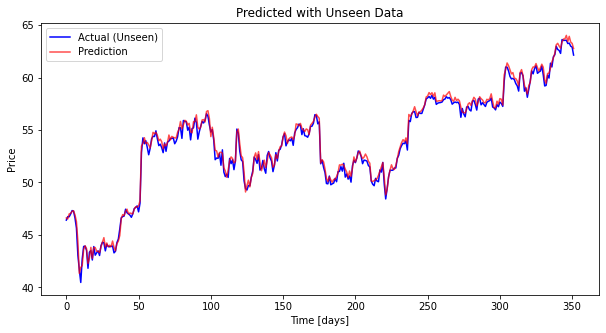

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(inv_y_test, color='blue', label='Actual (Unseen)')
plt.plot(inv_pred, color='red', alpha=0.7, label='Prediction')
plt.title('Predicted with Unseen Data')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

### Measure the Error of a Forcasting

In [ ]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(inv_y_test, inv_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(inv_y_test, inv_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(inv_y_test, inv_pred)))

Mean Absolute Error (MAE): 0.3276509973373411
Mean Squared Error (MSE): 0.16286101704616512
Root Mean Squared Error (RMSE): 0.403560425520349


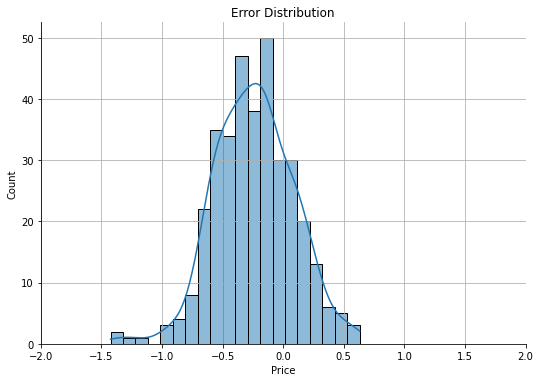

In [ ]:
sns.displot((inv_y_test-inv_pred), bins=20,
            kde=True, legend=False, aspect=1.5)
plt.title('Error Distribution')
plt.xlabel('Price')
plt.xlim([-2,2])
plt.grid()

# 8) Visualising Loss

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


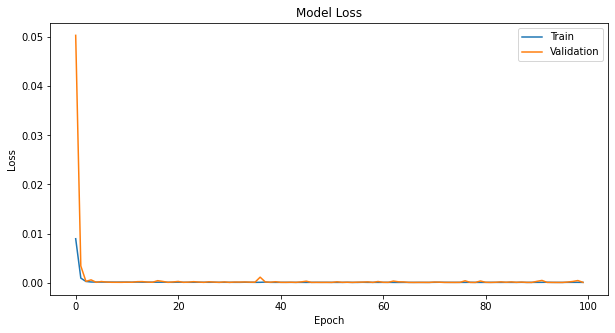

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')